# Projeto de portfólio - Health Insurance Cross Sell

# 0.0 Imports

In [61]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns

from scipy                 import stats as ss

import matplotlib.pyplot as plt

In [5]:
from IPython.display import Image
from IPython.core.display import HTML

## 0.1 Loading Datasets

In [6]:
df_raw = pd.read_csv("data/train.csv")

In [7]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2 Helper Functions

In [62]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container{width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [9]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data description

In [10]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [11]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data dimensions

In [12]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.3 Data types

In [13]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA

## 1.6 Change types

## 1.7 Descriptive statistical

In [15]:
num_attr = df1.select_dtypes(include = ['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [16]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew e kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T
d2 = pd.DataFrame(num_attr.apply(min)).T
d3 = pd.DataFrame(num_attr.apply(max)).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, d1, ct1, ct2, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'std', 'mean', 'median', 'skew', 'kurtosis']

In [17]:
m

,attributes,min,max,range,std,mean,median,skew,kurtosis
0,id,1.0,381109.0,381108.0,110016.691870,190555.000000,190555.0,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,15.511591,38.822584,36.0,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.046109,0.997869,1.0,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,13.229871,26.388807,28.0,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.498251,0.458210,0.0,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,17213.132474,30564.389581,31669.0,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,54.203924,112.034295,133.0,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,83.671194,154.347397,154.0,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.327935,0.122563,0.0,2.301906e+00,3.298788


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

In [19]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.1 Criação de hipótesis

## 2.2 Lista final de hipotesis

## 2.3 Feature engineering

In [20]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_and_2_year' if x == '1-2 Year' else 'below_1_year')
# vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Variables filtering

In [21]:
df3 = df2.copy()

# 4.0 Exploratory Analysis

In [22]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Numerical Attributes

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'driving_license'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'previously_insured'}>,
        <AxesSubplot:title={'center':'annual_premium'}>],
       [<AxesSubplot:title={'center':'policy_sales_channel'}>,
        <AxesSubplot:title={'center':'vintage'}>,
        <AxesSubplot:title={'center':'response'}>]], dtype=object)

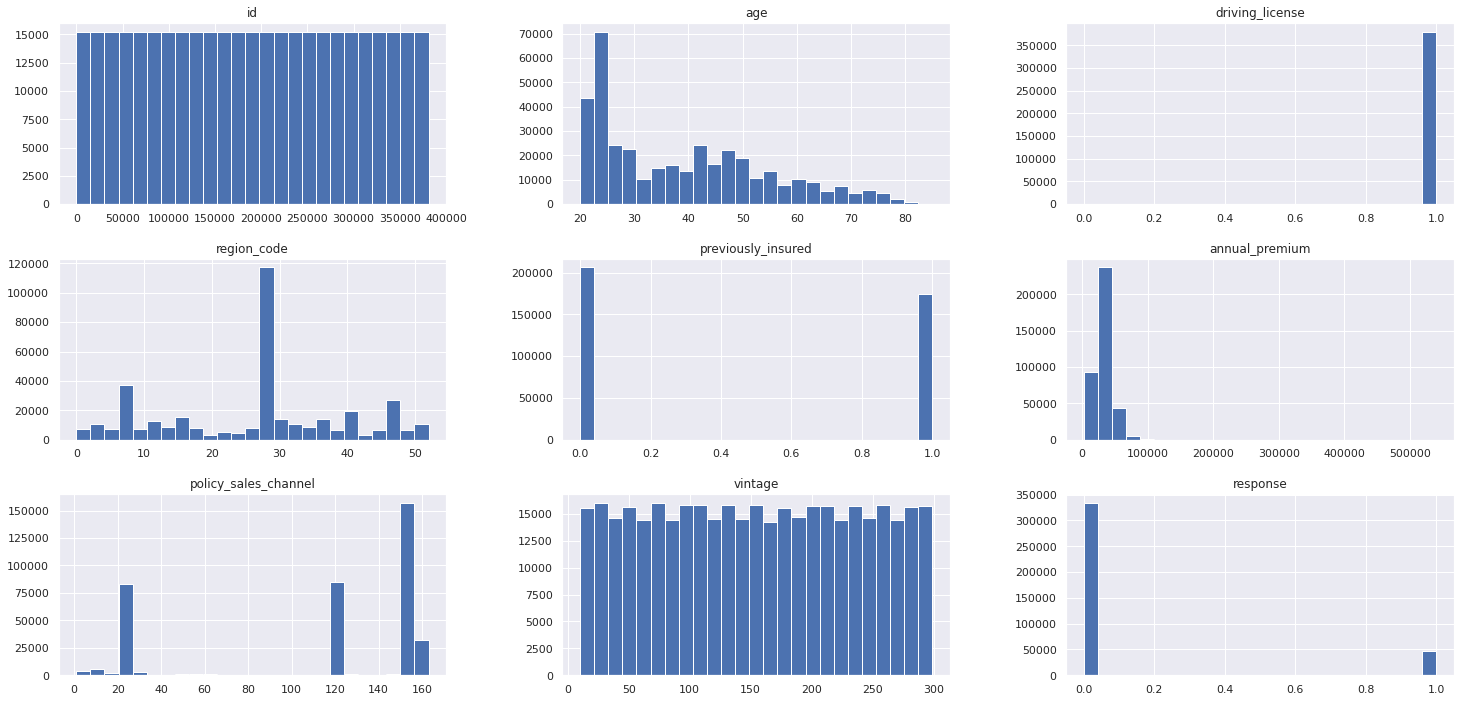

In [68]:
num_attr.hist(bins=25)

### 4.1.2 Categorical Attributes

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

<AxesSubplot:xlabel='response', ylabel='Density'>

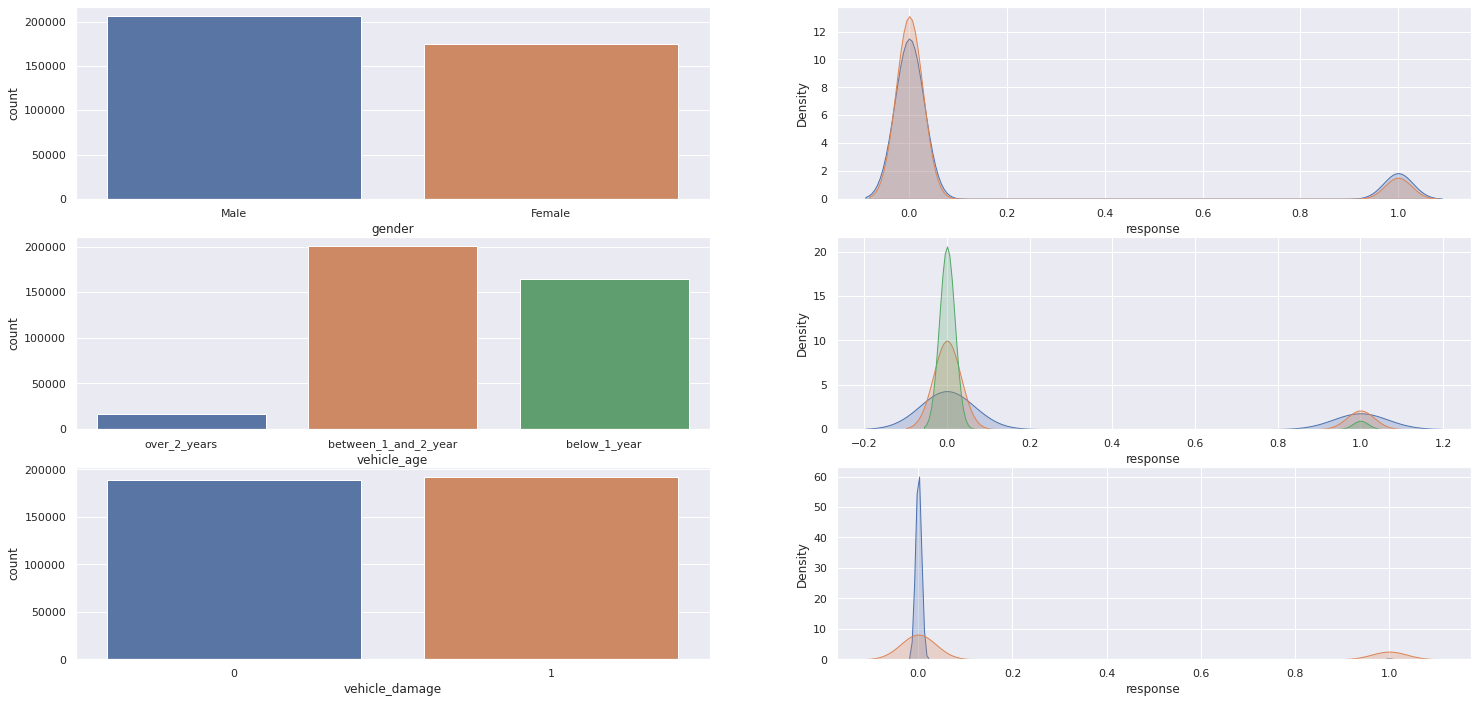

In [80]:
plt.subplot(3, 2, 1)
sns.countplot(df4['gender'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label='gender', shade=True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label='gender', shade=True)

plt.subplot(3, 2, 3)
sns.countplot(df4['vehicle_age'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['vehicle_age'] == 'over_2_years']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'between_1_and_2_year']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'below_1_year']['response'], label='vehicle_age', shade=True)

plt.subplot(3, 2, 5)
sns.countplot(df4['vehicle_damage'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['vehicle_damage'] == 0]['response'], label='vehicle_damage', shade=True)
sns.kdeplot(df4[df4['vehicle_damage'] == 1]['response'], label='vehicle_damage', shade=True)

## 4.2 Bivariete Analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

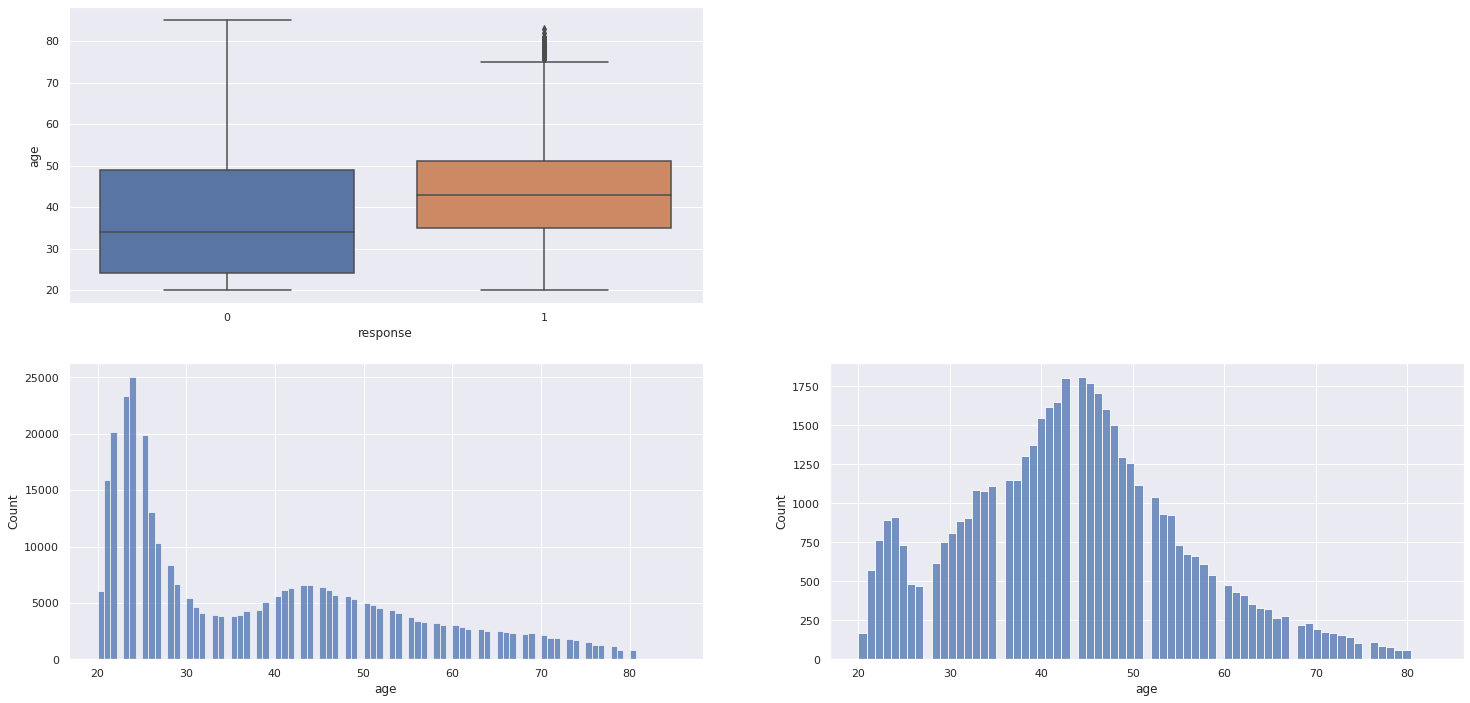

In [24]:
# age    
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux0)

In [25]:
# driving_license
aux = df4[['response', 'driving_license']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
#sns.barplot(x='response', y='driving_license_perc', data=aux)

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<AxesSubplot:xlabel='region_code', ylabel='id'>

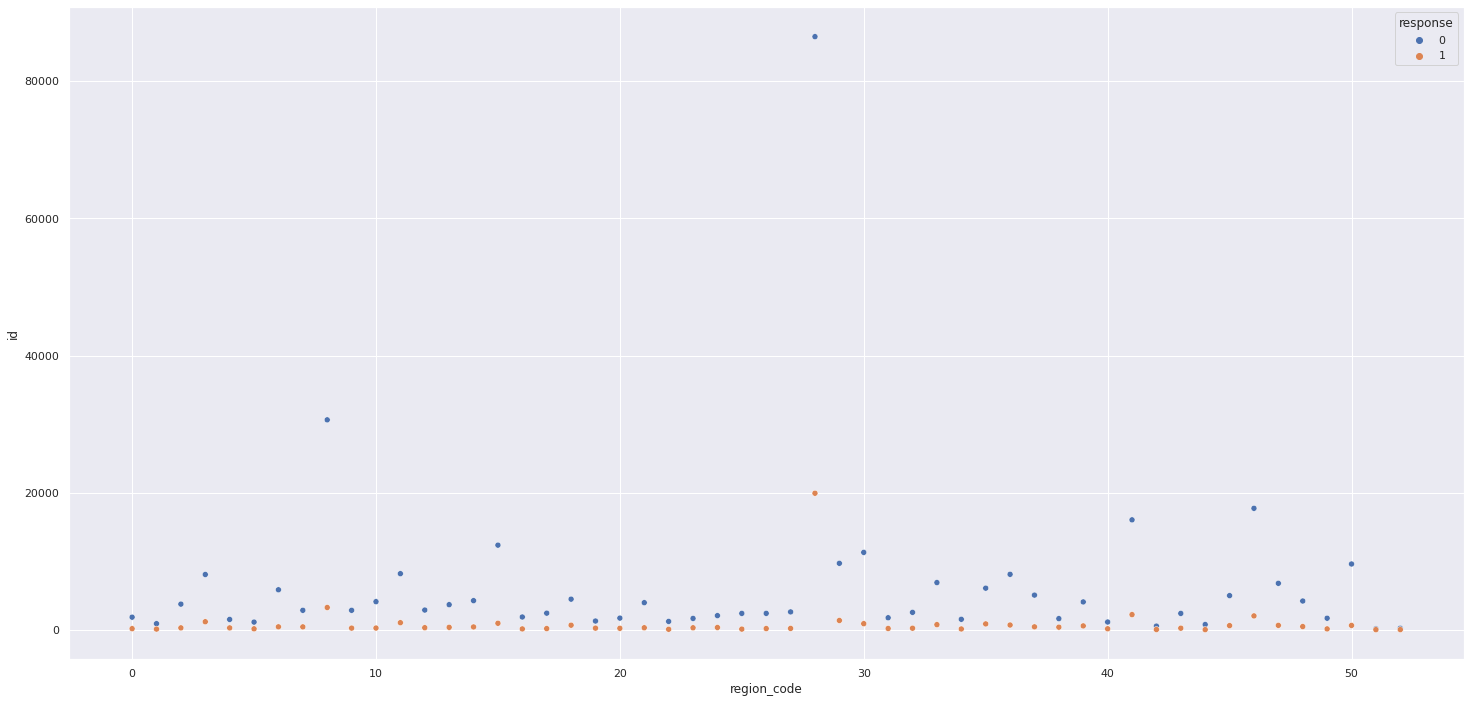

In [26]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [27]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [28]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_and_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_and_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [53]:
# vehicle_damage
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

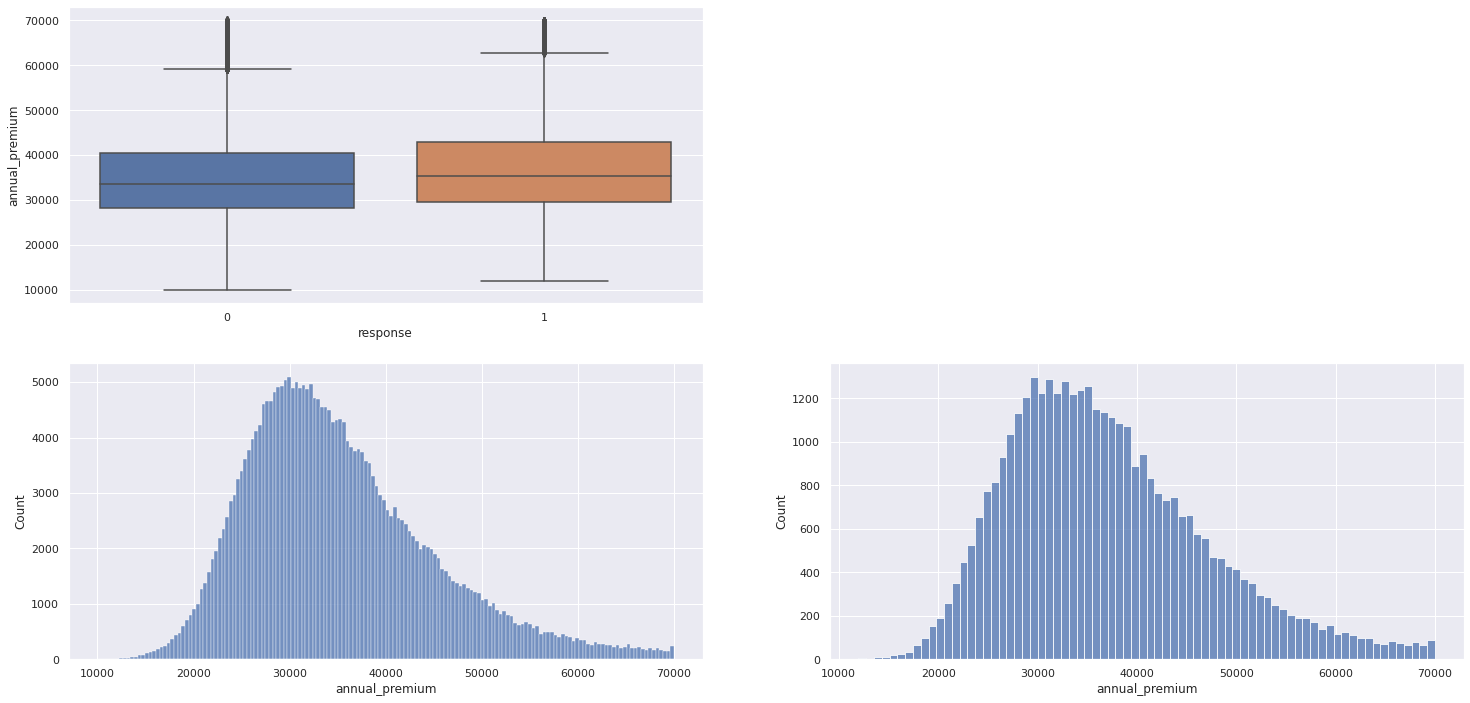

In [51]:
# annual_premium
plt.subplot(2, 2, 1)
aux = df4[(df4['annual_premium']<70000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response', y='annual_premium', data=aux)

plt.subplot(2, 2, 3)
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux0)

In [32]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
#aux.set_index('policy_sales_channel').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
aux

,policy_sales_channel,response
0,1.0,35
1,2.0,1
2,3.0,159
3,4.0,102
4,6.0,0
5,7.0,182
6,8.0,125
7,9.0,17
8,10.0,50
9,11.0,108


<AxesSubplot:xlabel='vintage', ylabel='Count'>

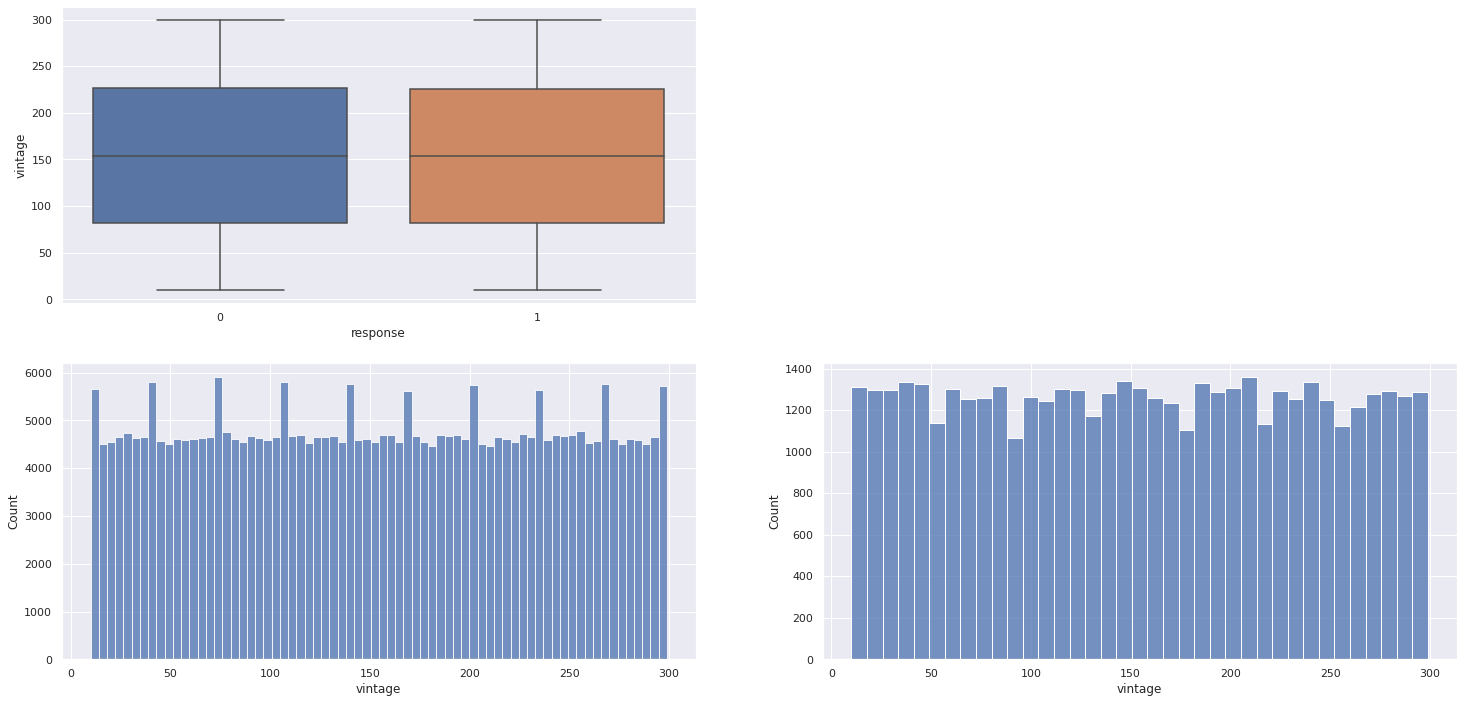

In [38]:
# vintage
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux0)

## 4.3 Multivariate Analysis

### 4.2.1 Numerical attributes

<AxesSubplot:>

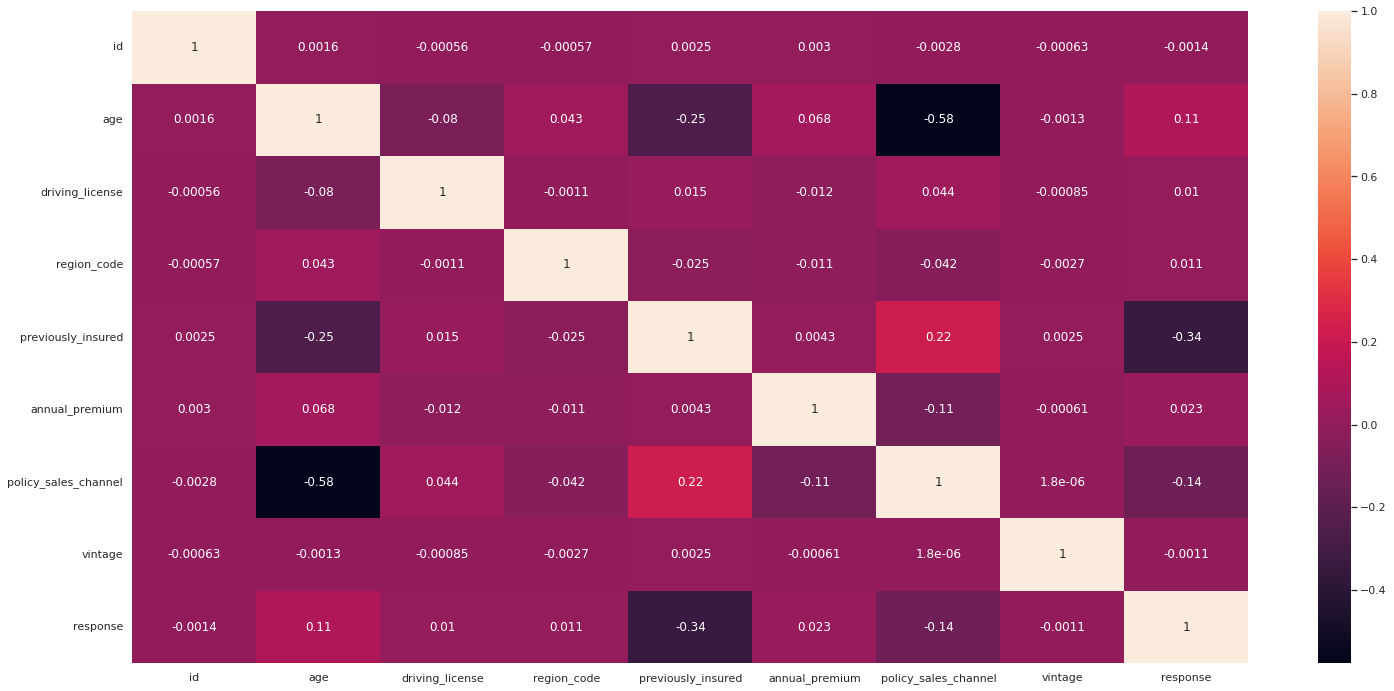

In [54]:
correlation = num_attr.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.2.2 Categorical attributes

In [57]:
cat_attr.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [63]:
# only categorical data
a = cat_attr

# Calculate cramver_v
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3],
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9]
                  } )

d = d.set_index(d.columns)

<AxesSubplot:>

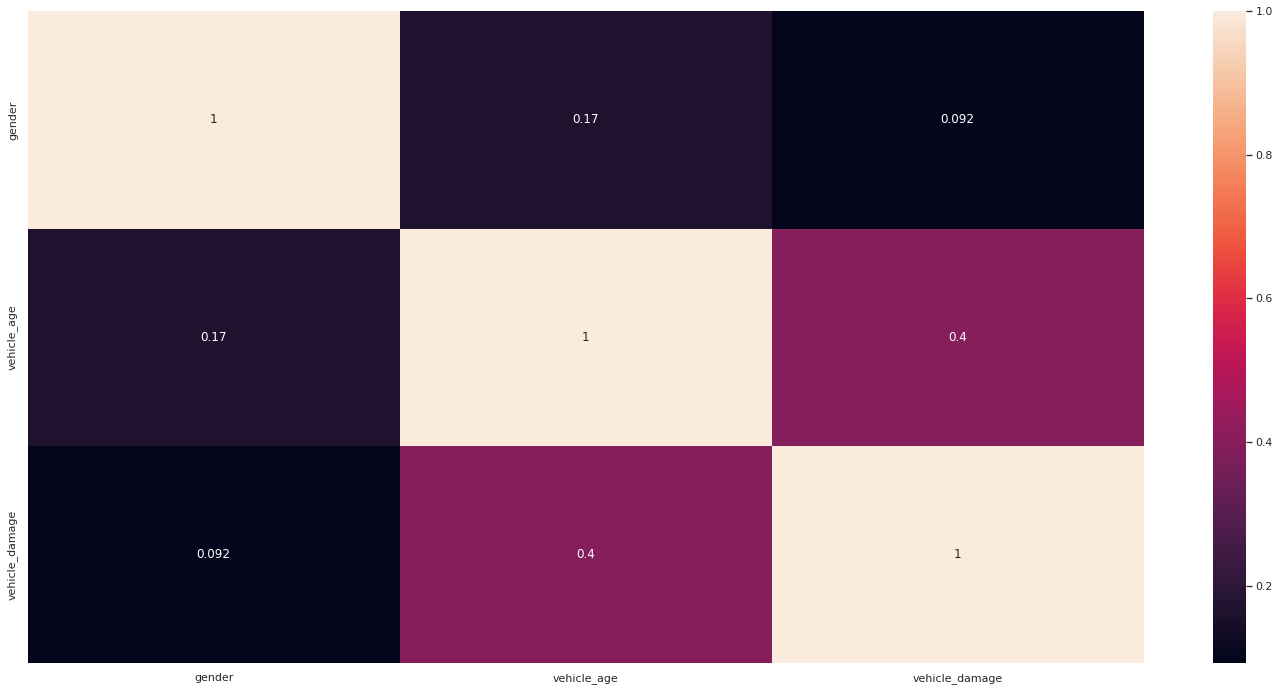

In [64]:
sns.heatmap(d, annot=True)

# 5.0 Data preparation

# 6.0 Feature selection

# 7.0 Machine learning modeling